In [1]:
# import the required libraries
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from matplotlib.image import imread 
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, AveragePooling2D,Flatten, Dense, Conv2D,MaxPool2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')
from keras import models
import matplotlib.pyplot as plt 



np.random.seed(42)


#**1 Research & Data Exploration**


## 1.1Research
https://www.sciencedirect.com/science/article/pii/S0263224120305844 


1.   Impact factor: 5.131
2.   Publication year: 2020




The selected article published in the Journal of the International Measurement Confederation aims to present Convolutional Neural Network models to early detect the insidious disease called Pneumonia which is one of the factors causing child mortality every year. 

In terms of methodology, various stages of work were put in to provide optimum results. To transform the format of the dataset, obtained from Kaggle, into more easily and effectively processed during the data mining stages preprocessing has been applied, followed by dividing the data into test and training sets. In the next step, a kernel of size 3x3 is selected to convolve over the input image in the main block of the algorithm – the Convolutional layer. Two activation functions are used in the CNN architecture - ReLu and SoftMax.  Without losing features that are critical for getting an accurate prediction the authors are using maxpooling and average pooling functions. While compiling the model Adam optimizer was used with a learning rate of 0.001. In order to prevent the model from overfitting the dropout regularization technique was employed along with changing the learning rate in some of the models. 

During the experiemnts, the Chest X-Ray Images (Pneumonia) dataset was tested and trained with 6 models using. To enhance the accuracy of the predictive network, the authors are using transfer learning. Consequently, 4 of the models were VGG16, VGG19, ResNet50 and Inception-v3. The other two – Model1 and Model2 consisted of 2 and 3 convolutional layers, respectively. Each model was trained for 20 epochs, with training & testing batch sizes of 32. It is worth noting that these networks are pre-trained on the ImageNet dataset. Supplying our model's with weights="imagenet" it is said to be beneficial for the overall performance as it helps the model converge in less epochs. 

To evaluate the overall performance of the predictive model the authors used Accuracy, F1 and Recall measures. The results in the paper are reported in a logical way. Model Accuracy and Model Loss graphs are generated for some of the best performing models. Among the CNN models, Model 2 appears to be the most efficient, having a score of 92.31%. Analyzing the results from the graphs clearly shows that VGG19 attained the highest accuracy and F1 Score of 95% and 9 predictive model's overall performance, the predictive model's overall performance, the 1% respectively compared with the other multilayered models. On the other hand, the ResNet50 and Inception-v3 show very poor performance. There is a clear overfitting as the difference between the training and validation accuracy is quite large. 

In terms of impressive results, Model2 and Vgg19 outperformed the other models and can be effectively used in a real world projects in the healthcare system.

To get even better results, the paper suggest applying fine-tuning on every parameter and hyper-paramete as well as using larger dataset.

## **1.2 Data Exploration**

In [2]:
#to access files, first mount the drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#show all the filder in the folder
!ls /content/gdrive/MyDrive/cs/chest_xray


model.h5  test	train  val


In [4]:
#data stored in google drive
main_dirction_path = '/content/gdrive/MyDrive/cs/chest_xray'
print(os.listdir(main_dirction_path))

['model.h5', 'test', 'val', 'train']


In [5]:
#path for train, test and val datasets
train_folder_path = main_dirction_path + '/train/'
test_folder_path = main_dirction_path + '/test/'
val_folder_path = main_dirction_path + '/val/'

#### Initializing labels and common parameters




In [6]:
labels = os.listdir(train_folder_path)
img_size = 118 # used for cnn
# img_size = 64 #used for the transfer learning
batch_size = 16
n_epochs = 25 
labels

['PNEUMONIA', 'NORMAL']

#### Defining the path to the positive and negative instances of the training and testing datasets

In [7]:
train_n_path = train_folder_path+'/NORMAL/'
train_p_path = train_folder_path+'/PNEUMONIA/'

test_n_path = test_folder_path+'/NORMAL/'
test_p_path = test_folder_path+'/PNEUMONIA/'

Checking the number of images in the training directory

In [8]:
print(f'Number of normal images (negative results) is {len(os.listdir(train_n_path))}') #length of normal training images
print(f'Number of postive images (positive results) is {len(os.listdir(train_p_path))}') #length of pneumonia training images

print(f'Total number of training images is {len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))}')

Number of normal images (negative results) is 1349
Number of postive images (positive results) is 3883
Total number of training images is 5232


Checking the number of images in the testing directory

In [9]:
print(f'Number of normal images (negative results) is {len(os.listdir(test_n_path))}') #length of normal training images
print(f'Number of postive images (positive results) is {len(os.listdir(test_p_path))}') #length of pneumonia training images

print(f'Total number of training images is {len(os.listdir(test_n_path)) + len(os.listdir(test_p_path))}')

Number of normal images (negative results) is 234
Number of postive images (positive results) is 390
Total number of training images is 624


In [10]:
#a function that extracts and load images according to the specified folder.
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### **Validation Set**
The train-test technique has been applied and will be used to estimate the performance of the algorithms when they are used to make a predictions if an image will be classified as pneumonia or normal.

In [11]:
train = get_training_data(train_folder_path)
temp = np.random.permutation(train) # Shuffle the data
train_size = 0.8 # Sets the split ratio

# Assigns 80% to training array and 20% to validation set
train, val = temp[:(int(train_size*len(temp)))], temp[int(train_size*len(temp)):]

In [12]:
#loading the dataset
test = get_training_data(test_folder_path)

In [13]:
#print the shape of each dataset
print(f'The shape of the training set is {train.shape}') 
print(f'The shape of the test set is {test.shape}') 
print(f'The shape of the val set is {val.shape}') 

The shape of the training set is (4185, 2)
The shape of the test set is (624, 2)
The shape of the val set is (1047, 2)


#### Show the class distribution for each dataset

<Axes: ylabel='count'>

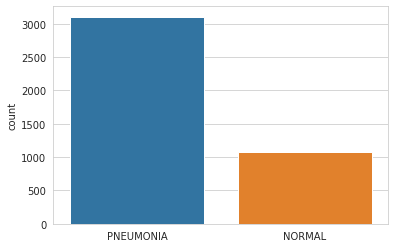

In [14]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("PNEUMONIA")
    else:
        l.append("NORMAL")
sns.set_style('whitegrid')
sns.countplot(x = l)  


<Axes: title={'center': 'Class distribution in the validation set'}, ylabel='count'>

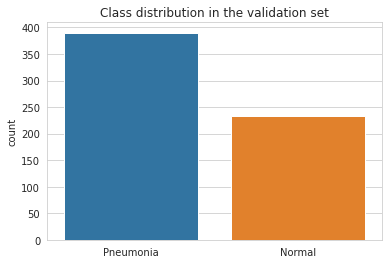

In [ ]:
l = []
sns.boxplot().set_title('Class distribution in the validation set')

for i in test:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('whitegrid')
sns.countplot(x = l)  


<Axes: title={'center': 'Class distribution in the validation set'}, ylabel='count'>

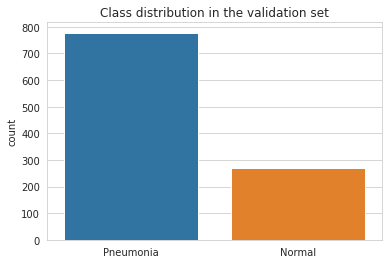

In [ ]:
l = []
sns.boxplot().set_title('Class distribution in the validation set')

for i in val:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('whitegrid')
sns.countplot(x = l)  


Based on results above we can easily notice that "Pneumonia" shows highest class distribution. To handle that imbalance and prevent the model from overfitting we need to use Data Augemntation.

#### A function to show random images 

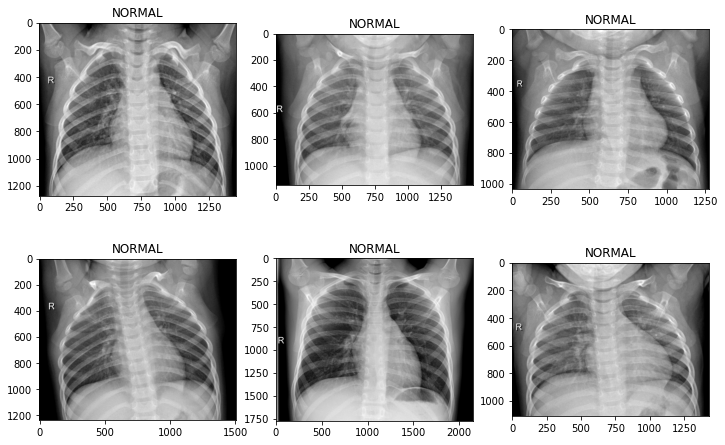

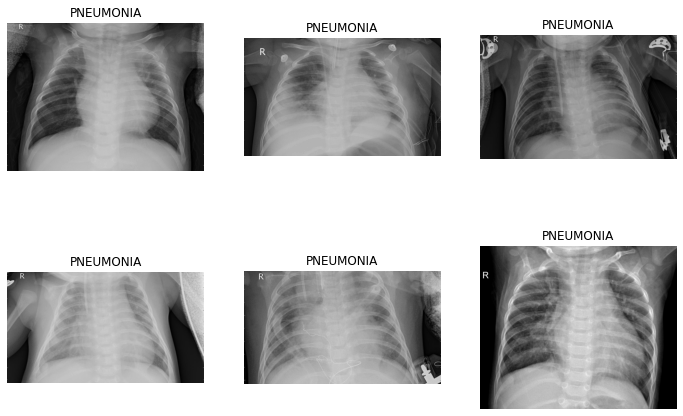

In [ ]:
def show_sample_images (number, normal=True):
    plt.figure(figsize=(12,12))
    if normal == True:
        for n in range(number):
            normal_img = os.listdir(train_n_path)[n]
            normal_img_address = train_n_path+normal_img
            normal_load = Image.open(normal_img_address)
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(normal_load, cmap ='gray')
            plt.title("NORMAL")
    else:
        for n in range(number):
            pneumonia_img =  os.listdir(train_p_path)[n]
            pneumonia_img_address = train_p_path+pneumonia_img
            pneumonia_load = Image.open(pneumonia_img_address)
            #cast nrows to integer
            ax = plt.subplot(int(number/2),int(number/2),n+1)
            plt.imshow(pneumonia_load, cmap ='gray')
            plt.title("PNEUMONIA")
            plt.axis("off")

# Show normal images
show_sample_images(6)

#Show images with pneumonia
show_sample_images(6, normal=False)

#### Histogram equalization to improve images contrast

In [ ]:
#!pip install scikit-image
from skimage import exposure

In [ ]:
def equlize_hist_ (image):
  _image = np.asarray(image)
  image_eq = exposure.equalize_hist(_image)
  return image_eq

In [ ]:
def improve_img_quality(Normal=True):
    if Normal==True:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_n_path))) 
        # image file name 
        img_expose_name = os.listdir(train_n_path)[random_img_ind]

        # path to the image
        img_expose_address = train_n_path+img_expose_name

        # load mage 
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Normal')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Normal after HE')
        plt.axis("off") 
    else:
        # Choose normal random image: generate random number between 1 and  the number of normal images in the training set
        random_img_ind= np.random.randint(0,len(os.listdir(train_p_path))) 
        # image file name 
        img_expose_name = os.listdir(train_p_path)[random_img_ind]

        # path to the image
        img_expose_address = train_p_path+img_expose_name

        # load mage 
        img_expose = Image.open(img_expose_address)
        img = np.asarray(img_expose)
        image_eq = equlize_hist_(img)
        figure1 = plt.figure(figsize= (16,16))
        img_1 = figure1.add_subplot(1,2,1)
        img_plot = plt.imshow(img, cmap = 'gray')
        img_1.set_title('Pneumonia')
        plt.axis("off")

        img2 = figure1.add_subplot(1, 2, 2)
        img_plot = plt.imshow(image_eq, cmap = 'gray')
        img2.set_title('Pneumonia after HE')
        plt.axis("off") 

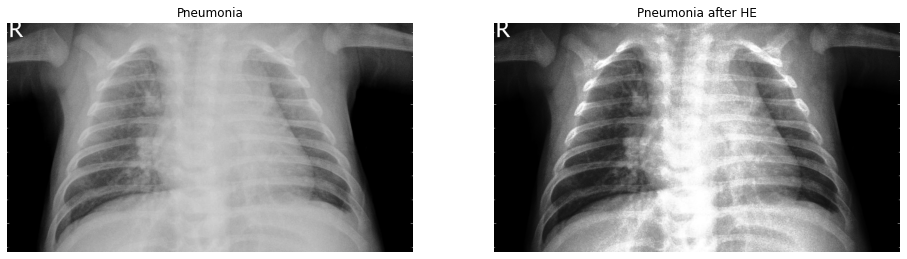

In [ ]:
improve_img_quality(False)


# **Baseline Model**

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [ ]:
print(f'Number of images in the training set is {len(x_train)}')

Number of images in the training set is 4185


In [ ]:
# Normalise the data 

x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

In [ ]:
# resize data for deep learning img_size is set to 64 by 64)
x_train = x_train.reshape(-1, img_size, img_size, 3)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 3)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 3)
y_test = np.array(y_test)

As mentioned above, Keras’ ImageDataGenerator class is used to perform data augmentation.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

#image generator used to allow my model to receive new variations of the images at each epoch
datagen = ImageDataGenerator(

      featurewise_center=False, 
      samplewise_center=False, 
      featurewise_std_normalization=False, 
      samplewise_std_normalization=False, 
      zca_whitening=False, 
      rotation_range = 30, 
      zoom_range = 0.2, 
      
      width_shift_range = 0.1, 
      height_shift_range = 0.1, 
      horizontal_flip = True, 
      vertical_flip=False) 

datagen.fit(x_train)



### CNN model

The first layer of the structure passes the input chest x-ray image of size 64 * 64 * 3 to the next parts. The feature extraction part includes three blocks where each block includes the convolution layer, batch normalization and maximum pooling layer. The first conv. layer has 32 feature maps, the second has 64 and the last 256. All of them use the ReLU activation function as it is faster to compute. The max pooling layer is responsible for recognizing the prominent features within the image and reducing the image’s dimensions. The batch normalization and the dropout layer(after the second Conv2D layer) have been added as suggested in a paper from 2022 by Al-Shourbaji et al. Batch normalization aims to standardize internal feature maps, and the dropout layer aims to avoid overfitting while aiding the model's generalization. The output of the future extraction part is passed to the final stage - the classification part. This process includes a flattened layer to change the shape of the data to a one-dimensional vector and pass it onto the Dense layers. The first dense layer has 128 output perceptrons employing ReLU and the second consists of one output perceptron using sigmoid. The next stage was compiling the neural net using binary_crossentropy loss function and NAdam optimizer as suggested in Hindawi journal. The number of parameters that are utilized in the CNN model for detecting pneumonia disease are demonstrated in the model summary section.

In [ ]:


# Model setup
model = Sequential()

model.add(Conv2D(32, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))

model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(Conv2D(64, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))

model.add(Conv2D(256, (3,3), strides = 1, padding = 'same', activation = 'relu', input_shape = (img_size, img_size, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2), strides = 2, padding = 'same'))


model.add(Flatten())

#full connection
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

model.compile(
              optimizer = 'nadam', loss = 'binary_crossentropy', 
              metrics = ['accuracy']
              )


In [ ]:
# model summary 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 118, 118, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 118, 118, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 59, 59, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 59, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 59, 59, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 59, 59, 64)       2

In [ ]:
#handle imbalance data
total = len(os.listdir(train_n_path)) + len(os.listdir(train_p_path))
neg = len(os.listdir(train_n_path))
pos = len(os.listdir(train_p_path))

weight_for_0 = 1 /neg * (total/2.0)
weight_for_1 = 1/pos *(total/2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}
class_weight

{0: 1.939214232765011, 1: 0.6737058975019315}

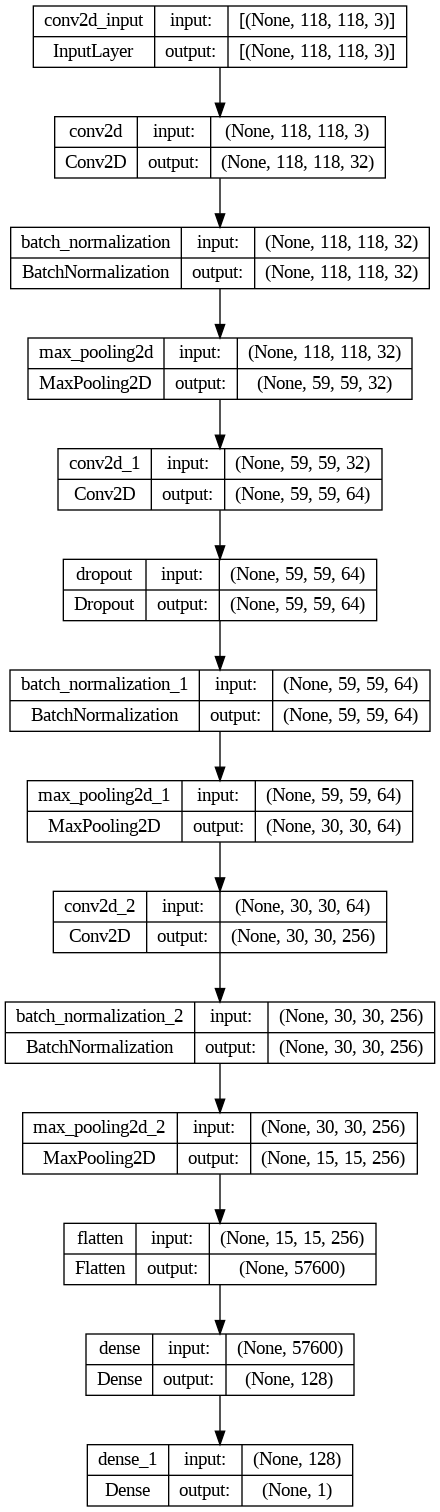

In [ ]:
#cnn structure
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

### Training Base Model

In [ ]:
batch_size = 32
n_epochs = 25

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
epochs = n_epochs , validation_data = datagen.flow(x_val,y_val) ,
callbacks = [learning_rate_reduction],
class_weight = class_weight)

Epoch 1/25
131/131 [==============================] - 29s 110ms/step - loss: 0.5685 - accuracy: 0.8225 - val_loss: 5.8654 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 2/25
131/131 [==============================] - 15s 117ms/step - loss: 0.2626 - accuracy: 0.8908 - val_loss: 5.3552 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 3/25
131/131 [==============================] - ETA: 0s - loss: 0.2228 - accuracy: 0.9049
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 15s 116ms/step - loss: 0.2228 - accuracy: 0.9049 - val_loss: 5.0844 - val_accuracy: 0.7431 - lr: 0.0010
Epoch 4/25
131/131 [==============================] - 15s 116ms/step - loss: 0.1908 - accuracy: 0.9216 - val_loss: 2.2970 - val_accuracy: 0.7431 - lr: 3.0000e-04
Epoch 5/25
131/131 [==============================] - 15s 116ms/step - loss: 0.1746 - accuracy: 0.9238 - val_loss: 1.7835 - val_accuracy: 0.7450 - lr: 3.0000e-04
Epoch 6/25
131/131 [=====================

In [ ]:
# model.save('/content/gdrive/MyDrive/cs/chest_xray/model.h5')


### Analyse results from trained base model


<Axes: >

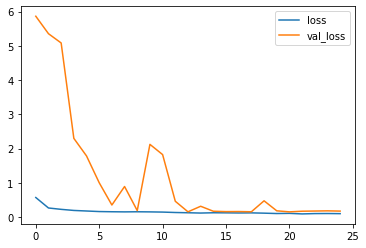

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

Text(0.5, 1.0, 'Fig 0')

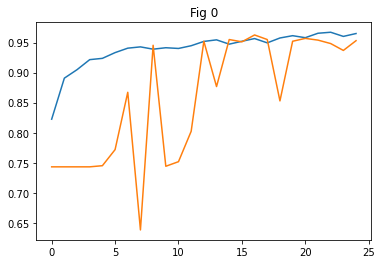

In [ ]:

plt.plot( losses[['accuracy','val_accuracy']])
plt.title("Fig 0")


#### Check the testing/accuracy loss

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 5ms/step - loss: 0.3117 - accuracy: 0.9054
Loss of the model is -  0.3117291033267975
20/20 [==============================] - 0s 5ms/step - loss: 0.3117 - accuracy: 0.9054
Accuracy of the model is -  90.54487347602844 %


#### Save the model and make some predictions

In [ ]:
predictions=model.predict(x_test) 
pred_labels= np.where(predictions>0.5, 1, 0)

20/20 [==============================] - 0s 4ms/step


In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, pred_labels, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.88      0.98      0.93       390
   Normal (Class 1)       0.95      0.79      0.86       234

           accuracy                           0.91       624
          macro avg       0.92      0.88      0.89       624
       weighted avg       0.91      0.91      0.90       624



#### Create a confusion matrix

<Axes: >

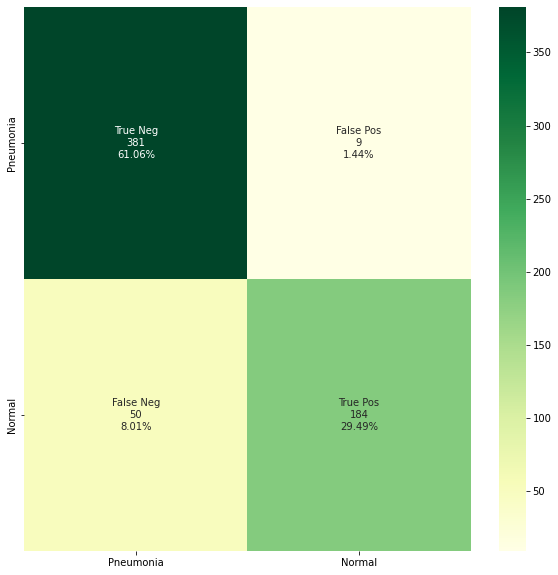

In [ ]:
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

In [ ]:
#creating a dataframe to store the actual labels and predicted ones

results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
37,0,1
50,0,1
84,0,1
96,0,1
104,0,1


In [ ]:
#display some results
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1

<Figure size 1440x1440 with 0 Axes>

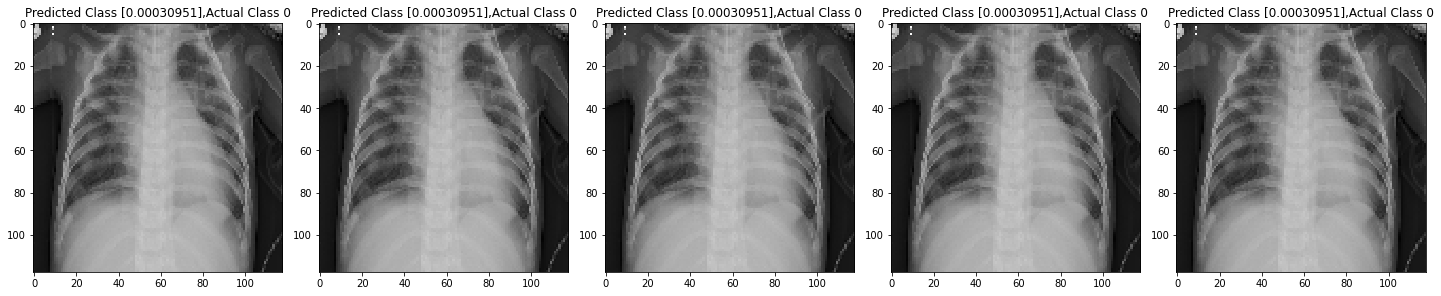

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1

# **Solution Improvement**

An interesting benefit of deep learning neural networks is that they can be reused on related problems. In the next section I am going to apply transfer learning technique. My aim is to accelerate the training and improve the performance of the CNN model and produce more accurate results if a patient will be diagnosed with pneumonia or not. For this purpose VGG19 and ResNet 50 will be used, fine tuning will be applied as well.

## VGG19
VGG19 is a variant of VGG model which in short consists of 19 layers (16 convolution layers, 3 Fully connected layer, 5 MaxPool layers and 1 SoftMax layer).
This will be the fisrt transfer learning model which will be applied.
According to the paper, VGG19 showed better performance compared to the other optimizers. 

In [ ]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)

for layer in base_model.layers:
  layer.trainable = False

In [ ]:

def get_pretrained(): 
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(32, activation='relu')(x)

    x = layers.Dense(64, activation='relu')(x)

    x = layers.Dropout(0.1)(x)


    x = layers.Dense(128, activation='relu')(x)
    
    x = layers.Flatten()(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=output)

    
    return model

In [ ]:
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(), metrics='accuracy')

model_pretrained.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 32)                16416     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                           

In [ ]:
history_tl = model_pretrained.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    class_weight = class_weight
                   )

Epoch 1/25
131/131 [==============================] - 9s 54ms/step - loss: 0.4876 - accuracy: 0.7565 - val_loss: 0.3510 - val_accuracy: 0.8415 - lr: 0.0010
Epoch 2/25
131/131 [==============================] - 8s 61ms/step - loss: 0.3029 - accuracy: 0.8473 - val_loss: 0.3355 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 3/25
131/131 [==============================] - 9s 67ms/step - loss: 0.2758 - accuracy: 0.8707 - val_loss: 0.3430 - val_accuracy: 0.8653 - lr: 0.0010
Epoch 4/25
131/131 [==============================] - 7s 51ms/step - loss: 0.2659 - accuracy: 0.8736 - val_loss: 0.2643 - val_accuracy: 0.8892 - lr: 0.0010
Epoch 5/25
131/131 [==============================] - 8s 59ms/step - loss: 0.2492 - accuracy: 0.8798 - val_loss: 0.3723 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 6/25
130/131 [============================>.] - ETA: 0s - loss: 0.2581 - accuracy: 0.8774
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 8s 62

<Axes: >

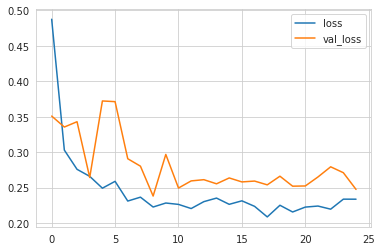

In [ ]:
losses = pd.DataFrame(model_pretrained.history.history)
losses[['loss','val_loss']].plot()

Text(0.5, 1.0, 'Fig 1')

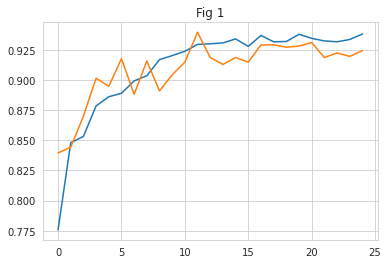

In [ ]:
plt.plot( losses[['accuracy','val_accuracy']])
plt.title("Fig 1")

In [ ]:
print("Loss of the model is - " , model_pretrained.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 22ms/step - loss: 0.3553 - accuracy: 0.8478
Loss of the model is -  0.35529252886772156
20/20 [==============================] - 0s 19ms/step - loss: 0.3553 - accuracy: 0.8478
Accuracy of the model is -  84.77563858032227 %


#### Save the model and make some predictions

In [ ]:
# model_pretrained.save('/content/gdrive/MyDrive/cs/chest_xray/vgg16.h5')


20/20 [==============================] - 0s 20ms/step


<Axes: >

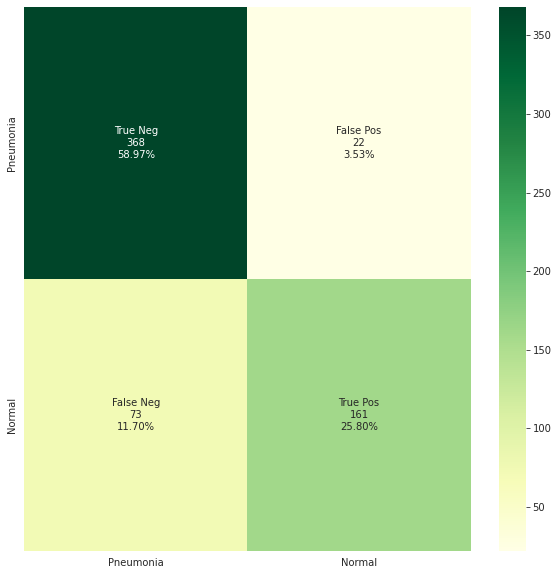

In [ ]:

predictions=model_pretrained.predict(x_test) 
pred_labels= np.where(predictions>0.5, 1, 0)
#create a confusion matrix
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

In [ ]:
#creating a dataframe to store the actual labels and predicted ones

results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
28,0,1
38,0,1
70,0,1
72,0,1
87,0,1


In [ ]:
#display some results
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1

<Figure size 1440x1440 with 0 Axes>

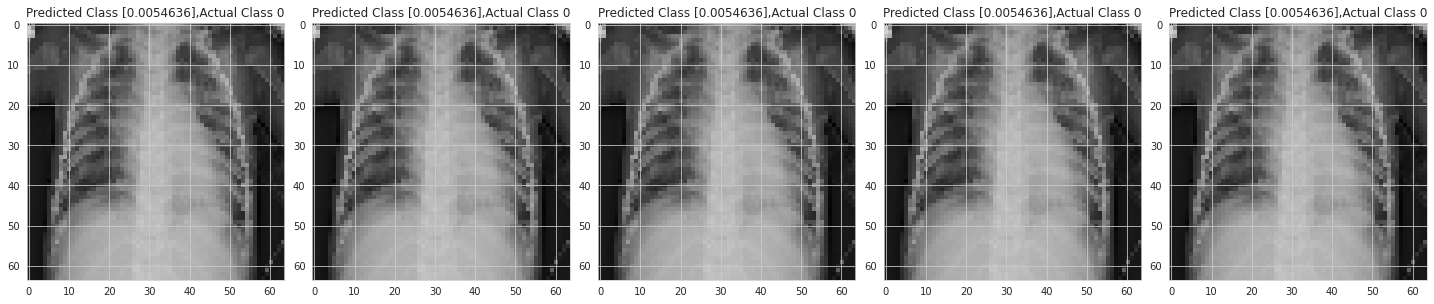

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(64,64,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1

After taking closer look at the results achieved by VGG19 I can clearly see the algorithm is not performing very well. It does not look like the model actually learns much because the accuracy starts and ends at nearly the same value. 

## VGG19 with fine tuning

In [ ]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.VGG19(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
# base_model.trainable = False


for layer in base_model.layers[:10]:
  layer.trainable = False

#make sure i have frozen the correct layers
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_conv4 True
11 block3_pool True
12 block4_conv1 True
13 block4_conv2 True
14 block4_conv3 True
15 block4_conv4 True
16 block4_pool True
17 block5_conv1 True
18 block5_conv2 True
19 block5_conv3 True
20 block5_conv4 True
21 block5_pool True


In [ ]:

def get_pretrained(): 
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(32, activation='relu')(x)

    x = layers.Dense(64, activation='relu')(x)

    # x = layers.Dropout(0.1)(x)


    x = layers.Dense(128, activation='relu')(x)
    
    x = layers.Flatten()(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=output)

    
    return model

In [ ]:
model_pretrained_vgg19_tuning = get_pretrained()
model_pretrained_vgg19_tuning.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(), metrics='accuracy')

model_pretrained_vgg19_tuning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                16416     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                             

In [ ]:
batch_size = 32
n_epochs = 25
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history_tl = model_pretrained_vgg19_tuning.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    class_weight = class_weight
                   )

Epoch 1/25
131/131 [==============================] - 14s 75ms/step - loss: 0.6507 - accuracy: 0.7367 - val_loss: 0.5584 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 2/25
131/131 [==============================] - 10s 73ms/step - loss: 0.3792 - accuracy: 0.7768 - val_loss: 0.3333 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 3/25
131/131 [==============================] - 10s 72ms/step - loss: 0.2984 - accuracy: 0.8643 - val_loss: 0.3533 - val_accuracy: 0.8644 - lr: 0.0010
Epoch 4/25
131/131 [==============================] - 9s 71ms/step - loss: 0.2817 - accuracy: 0.8722 - val_loss: 0.2732 - val_accuracy: 0.8758 - lr: 0.0010
Epoch 5/25
131/131 [==============================] - 9s 65ms/step - loss: 0.2903 - accuracy: 0.8559 - val_loss: 0.3200 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 6/25
131/131 [==============================] - 10s 73ms/step - loss: 0.2743 - accuracy: 0.8722 - val_loss: 0.3040 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 7/25
131/131 [==============================] - 10s 74

In [ ]:
# from tensorflow.keras.models import load_model
# vgg19_ft_load = load_model('/content/gdrive/MyDrive/cs/chest_xray/vgg19_ft_90.86.h5')


In [ ]:
losses = pd.DataFrame(model_pretrained_vgg19_tuning.history.history)
losses[['loss','val_loss']].plot()

In [ ]:
print("Loss of the model is - " , model_pretrained_vgg19_tuning.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained_vgg19_tuning.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 18ms/step - loss: 0.3030 - accuracy: 0.9087
Loss of the model is -  0.3029851019382477
20/20 [==============================] - 0s 14ms/step - loss: 0.3030 - accuracy: 0.9087
Accuracy of the model is -  90.86538553237915 %


In [ ]:
# model_pretrained_vgg19_tuning.save('/content/gdrive/MyDrive/cs/chest_xray/vgg19_ft_90.86.h5')


#### Save the model and make some predictions

In [ ]:
# vgg19_ft_load.save('/content/gdrive/MyDrive/cs/chest_xray/vgg19_ft_load.h5')


20/20 [==============================] - 0s 18ms/step


<Axes: >

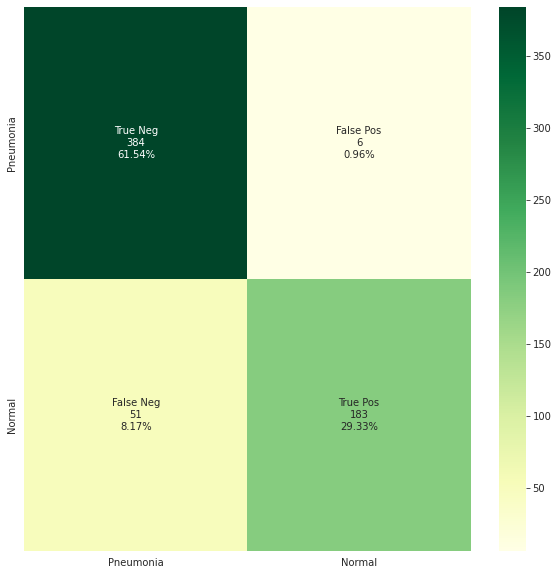

In [ ]:
predictions=model_pretrained_vgg19_tuning.predict(x_test) 
pred_labels= np.where(predictions>0.5, 1, 0)
#create a confusion matrix
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

In [ ]:
#creating a dataframe to store the actual labels and predicted ones

results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
35,0,1
98,0,1
149,0,1
252,0,1
289,0,1


In [ ]:
#display some results
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

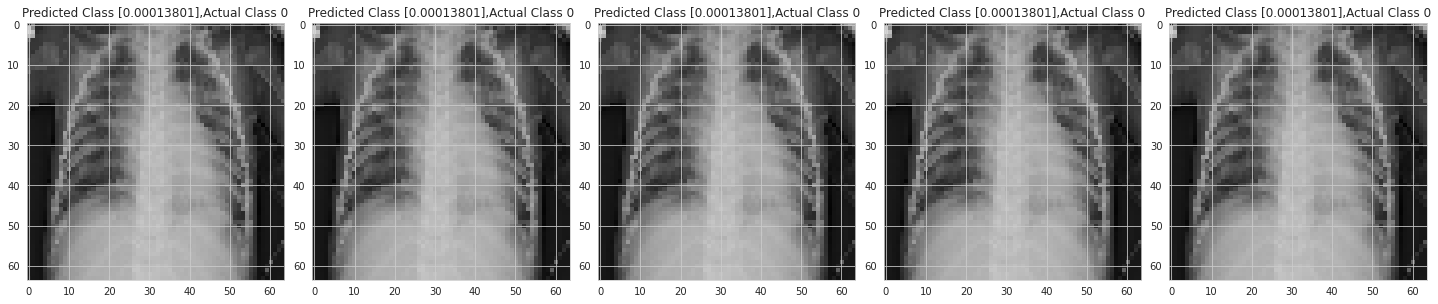

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(64,64,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1

After freezing the bottom 10 layers, I can notice singificant improvement in the accuracy compared with normal VGG19. Moreover, the overfitting is solved and this time the false positive values(= patient is diagnosed with pneumonia although he is healthy) are 6, whereas the normal VGG19 showed 22.

## Resnet50 without fine tuning

ResNet-50 is a convolutional neural network that is 50 layers deep.

In [ ]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers

for layer in base_model.layers:
  layer.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:

def get_pretrained(): 
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(32, activation='relu')(x)

    x = layers.Dense(64, activation='relu')(x)

    # x = layers.Dropout(0.1)(x)


    x = layers.Dense(128, activation='relu')(x)
    
    x = layers.Flatten()(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=output)

    
    return model

In [ ]:
model_pretrained_resnet_no_ft = get_pretrained()
model_pretrained_resnet_no_ft.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(), metrics='accuracy')

model_pretrained_resnet_no_ft.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                             

In [ ]:
history_tl = model_pretrained_resnet_no_ft.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    class_weight = class_weight
                   )

Epoch 1/25
131/131 [==============================] - 23s 127ms/step - loss: 0.5467 - accuracy: 0.7419 - val_loss: 0.5240 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 2/25
131/131 [==============================] - 9s 66ms/step - loss: 0.4101 - accuracy: 0.7768 - val_loss: 0.4168 - val_accuracy: 0.7927 - lr: 0.0010
Epoch 3/25
131/131 [==============================] - 8s 58ms/step - loss: 0.3877 - accuracy: 0.7976 - val_loss: 0.3935 - val_accuracy: 0.8118 - lr: 0.0010
Epoch 4/25
131/131 [==============================] - 9s 68ms/step - loss: 0.3599 - accuracy: 0.8148 - val_loss: 0.3762 - val_accuracy: 0.8214 - lr: 0.0010
Epoch 5/25
131/131 [==============================] - 9s 65ms/step - loss: 0.3657 - accuracy: 0.8119 - val_loss: 0.4405 - val_accuracy: 0.7985 - lr: 0.0010
Epoch 6/25
131/131 [==============================] - 8s 60ms/step - loss: 0.3475 - accuracy: 0.8241 - val_loss: 0.3434 - val_accuracy: 0.8309 - lr: 0.0010
Epoch 7/25
131/131 [==============================] - 9s 67ms/

<Axes: >

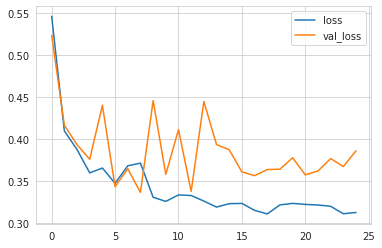

In [ ]:
losses = pd.DataFrame(model_pretrained_resnet_no_ft.history.history)
losses[['loss','val_loss']].plot()

Text(0.5, 1.0, 'Fig 3')

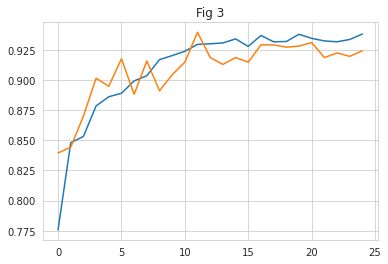

In [ ]:
plt.plot( losses[['accuracy','val_accuracy']])
plt.title("Fig 3")

In [ ]:
print("Loss of the model is - " , model_pretrained_resnet_no_ft.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained_resnet_no_ft.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 1s 39ms/step - loss: 0.4744 - accuracy: 0.7756
Loss of the model is -  0.4743771255016327
20/20 [==============================] - 0s 17ms/step - loss: 0.4744 - accuracy: 0.7756
Accuracy of the model is -  77.56410241127014 %


#### Save the model and make some predictions

In [ ]:
# model_pretrained_resnet_no_ft.save('/content/gdrive/MyDrive/cs/chest_xray/model_pretrained_resnet_no_ft.h5') # 


20/20 [==============================] - 1s 19ms/step


<Axes: >

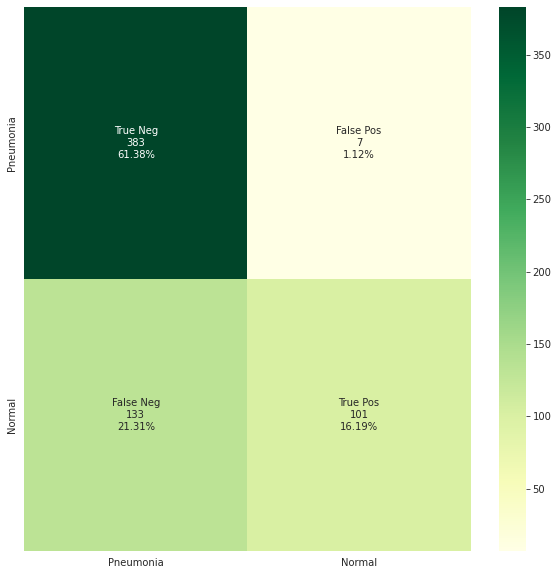

In [ ]:
predictions=model_pretrained_resnet_no_ft.predict(x_test) 
pred_labels= np.where(predictions>0.5, 1, 0)
#create a confusion matrix
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

In [ ]:
#creating a dataframe to store the actual labels and predicted ones

results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
98,0,1
118,0,1
229,0,1
315,0,1
337,0,1


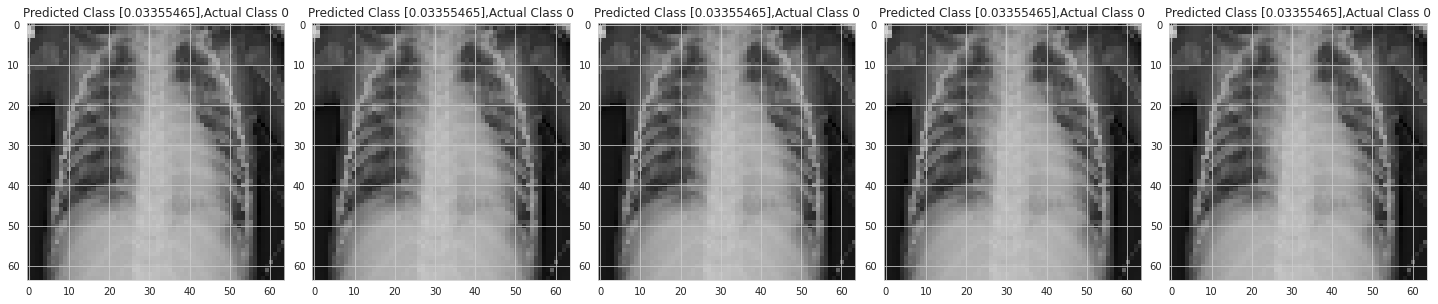

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(64,64,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1

## ResNet50 with fine tuning

In [ ]:
tf.keras.backend.clear_session()

base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    input_shape=(img_size, img_size, 3),
    include_top=False)
# freeze the layers
# base_model.trainable = False


for layer in base_model.layers[:10]:
  layer.trainable = False

#make sure i have frozen the correct layers
for i, layer in enumerate(base_model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_

In [ ]:

def get_pretrained(): 
    
    #Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(img_size,img_size, 3))
    
    x = base_model(inputs)

    # Head
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(32, activation='relu')(x)

    x = layers.Dense(64, activation='relu')(x)

    # x = layers.Dropout(0.1)(x)


    x = layers.Dense(128, activation='relu')(x)
    
    x = layers.Flatten()(x)

    #Final Layer (Output)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=[inputs], outputs=output)

    
    return model

In [ ]:
model_pretrained_resnet_tuning = get_pretrained()
model_pretrained_resnet_tuning.compile(loss='binary_crossentropy'
              , optimizer = tf.keras.optimizers.Adam(), metrics='accuracy')

model_pretrained_resnet_tuning.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 32)                65568     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                             

In [ ]:
history_tl = model_pretrained_resnet_tuning.fit(datagen.flow(x_train,y_train, batch_size = batch_size) ,
                    epochs = n_epochs , validation_data = datagen.flow(x_val, y_val) ,
                    callbacks = [learning_rate_reduction],
                    class_weight = class_weight
                   )

Epoch 1/25
131/131 [==============================] - 55s 99ms/step - loss: 0.3021 - accuracy: 0.8636 - val_loss: 2.5965 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 2/25
131/131 [==============================] - 13s 100ms/step - loss: 0.2209 - accuracy: 0.9056 - val_loss: 1.1549 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 3/25
131/131 [==============================] - ETA: 0s - loss: 0.1880 - accuracy: 0.9262
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
131/131 [==============================] - 12s 88ms/step - loss: 0.1880 - accuracy: 0.9262 - val_loss: 0.7039 - val_accuracy: 0.7345 - lr: 0.0010
Epoch 4/25
131/131 [==============================] - 10s 75ms/step - loss: 0.1515 - accuracy: 0.9412 - val_loss: 0.5759 - val_accuracy: 0.7345 - lr: 3.0000e-04
Epoch 5/25
131/131 [==============================] - ETA: 0s - loss: 0.1349 - accuracy: 0.9522
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
131/131 [=========================

<Axes: >

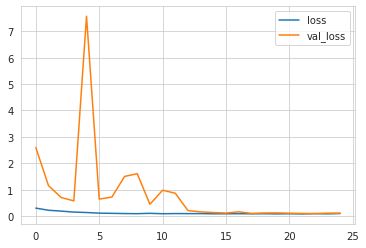

In [ ]:
losses = pd.DataFrame(model_pretrained_resnet_tuning.history.history)
losses[['loss','val_loss']].plot()

Text(0.5, 1.0, 'Fig4')

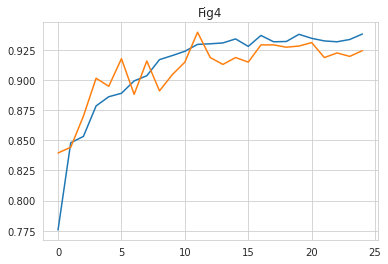

In [ ]:

# plt = losses[['accuracy','val_accuracy']].plot()
plt.plot( losses[['accuracy','val_accuracy']])
plt.title("Fig 4")

In [ ]:
print("Loss of the model is - " , model_pretrained_resnet_tuning.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model_pretrained_resnet_tuning.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 21ms/step - loss: 0.2116 - accuracy: 0.9199
Loss of the model is -  0.2115759700536728
20/20 [==============================] - 0s 18ms/step - loss: 0.2116 - accuracy: 0.9199
Accuracy of the model is -  91.98718070983887 %


### Some discussions about ResNet50 performance

ResNet50 with fine tuning achieved 91.98% accuracy with only 0.21 loss as described above. It definetly seems to outperform the other models above. VGG19 with fine tuning has lower accuracy (90.86%) and loss of 32.
 Great accuracy with low loss means that the model made low errors on a few data. Consequently, fine-tuned ResNet50 has a higher chance of predicting the right condition of the patient compared with the other algorithms.


### Save the model and make some predictions

In [ ]:
# model_pretrained_resnet_tuning.save('/content/gdrive/MyDrive/cs/chest_xray/model_pretrained_resnet_tuning.h5') # 


20/20 [==============================] - 0s 19ms/step


<Axes: >

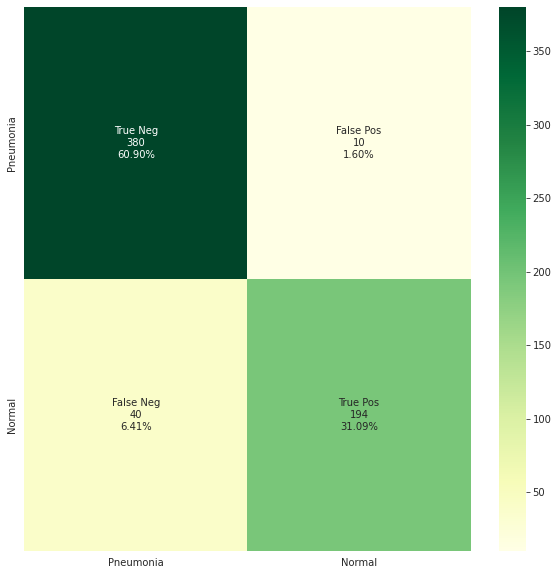

In [ ]:
predictions=model_pretrained_resnet_tuning.predict(x_test) 
pred_labels= np.where(predictions>0.5, 1, 0)
#create a confusion matrix
cf_matrix = confusion_matrix(y_test, pred_labels)
plt.figure(figsize = (10,10))
classes = ['Pneumonia','Normal']
labels = ['TN','FP','FN','TP']
labels = np.asarray(labels).reshape(2,2)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap= "YlGn" ,
            xticklabels = classes,yticklabels = classes
           )

In [ ]:
#creating a dataframe to store the actual labels and predicted ones

results = pd.DataFrame({'Actual':y_test,'Predicted':pred_labels.flatten()})

incorrect_df = results[results.Actual!=results.Predicted]
incorrect_df.head()

,Actual,Predicted
35,0,1
54,0,1
72,0,1
98,0,1
99,0,1


In [ ]:
#display some results
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in correct[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(img_size,img_size,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {}, Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1

<Figure size 1440x1440 with 0 Axes>

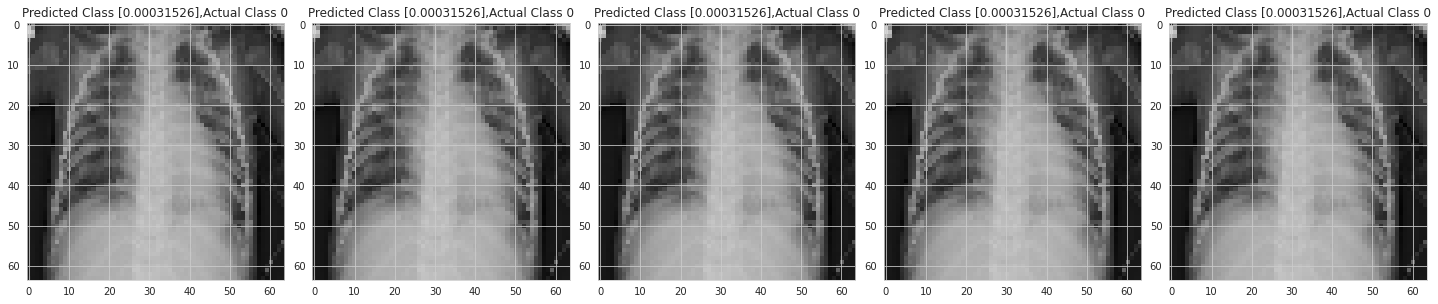

In [ ]:
i = 0
figure = plt.figure(figsize= (20,20))

for c in incorrect[:5]:
    ax = plt.subplot(5,5,i+1)
    plt.imshow(x_test[c].reshape(64,64,3), cmap="gray",interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c],y_test[c]))
    plt.tight_layout()
    i += 1

# Results from all models



*  **CNN Base Model** = 90.54 %

*   **VGG19** =  84.77%

*   **VGG19 with fine tuning** = 90.86%

*   **ResNet50** =  77.56%

*   **ResNet50 with fine tuning** = 91.98%


# Conclusion & Future Direction


The project shown above was an evaluation of different kinds of neural network models for real-time applications.  The presented solution is trained on the chest X-ray images dataset. This dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 types (Pneumonia/Normal). 



As suggested in the paper, the image size was set to 64 by 64. After a few experiments using 224x224, I concluded that this size does not meet the ram requirements on my machine. For this purpose, extra research has been done about the effect of image resolution on deep learning in radiography. Based on the gathered information, when using a dataset smaller than ImageNet, a smaller image size might lead to higher results.
Each model was run with a batch size of 16 for 25 epochs. 
```
batch_size = 16 
n_epochs = 25
```


To help our neural netowork classifier to reduce overfitting Data augmentation has been applied. More precisely, I increased the number of data used for training by creating more image samples using rotations, scalling and flipping.


```
datagen = ImageDataGenerator( 

      featurewise_center=False,  
      samplewise_center=False,  
      featurewise_std_normalization=False,  
      samplewise_std_normalization=False,  
      zca_whitening=False,  
      rotation_range = 30,  
      zoom_range = 0.2,  
      width_shift_range = 0.1,  
      height_shift_range = 0.1,  
      horizontal_flip = True,  
      vertical_flip=False)
```
The function ‘ReduceLROnPlateau’ has been applied when training the models in order to change the learning rates throughout training process.

The proposed CNN model is the first applied alogirthm to detect pneumonia. The model had training accuracy and training loss of 90.54% and 0.31, respectively.
The precision shown in the graph is 0.92, it is responsible for how many of observations are really positive and how exact the model is. The recal is the total number ot true values. In this scenario, the CNN model has a slightly low recal of 0.88 which means there is a significant chance of predicting a wrong diagnose.

Regarding solution improvement, I decided to use VGG19 and ResNet50. According to the peer reviewed paper VGG19 has better overall performance compared to the other models including ResNet50.  
As shown in Fig1 and Fig3 VGG19 obtained 84.77% accuracy, and ResNet50 - 77.56 respectively. The validation loss is 0.35 for VGG19 and 0.45 for the ResNet.This proves the statement form the paper that VGG19 is more accurate than ResNet. However, these results can be significantly improved. Especially in the healthcare industry where the machine learning algorithms are used as a tool to  develop better diagnostic the accuracy is crucial. 

It is worth mentioning that fine tuning has not been applied to the tranfer learning models in the aforementioned paper. For this reason, I decided to test if that technique might leads to better results. I froze the last 15 layers for both algorithms. The outcomes we can analyze are quite interesting.  The graph shows 90.86 accuracy for VGG19 with fine tuning applied and 91.98 for ResNet50.  
The CNN model achieves 90.54% accuracy using 3 conv. layers, whereas the highest result is obtained using 50-layer convolutional neural network. We can notice 1.44% improvement with ResNet50 fine tuning compared to CNN. The ResNet50 with fine tuning appears to handle new data better comparing its loss function with CNN`s. 
In addition, the aim of the confusion metrix is to maximize the metrics with the word True, and minimize the other two metrics (False Positive and False Negative). Looking at the final results we can clearly see both fine tuned models achieved this goal. ResNet50 with fine tuning showed only 6.41% false negative values(times the model incorrectly classify a a patient with a pneumonia as a healthy), whereas normal ResNet50 and VGG19 achieved 26.6% and 11.70% respectively.

In the future work, to achieve higher performance the image size might be set to 224x224 and the number of hidden layers may be increased for the deep convolutions in the model.
According to the Northshore there are 3 types of Pneumonia - Viral, Bacterial and Mycoplasma based on the area of the lung involved. Developing an algorithm which can identify which parts of the lungs have been affected will be a good way to classify the type of pneumonia but more over it will highlight the affected lung area in case of emergency situation. To improve the current solution it might be beneficial if neural network models based on GAN, generative adversarial networks are trained and compared with the existing models.













#####References:
Al-Shourbaji, I., Kachare, P. H., Abualigah, L., Abdelhag, M. E., Elnaim, B., Anter, A. M., & Gandomi, A. H. (2022). A deep batch normalized convolution approach for improving COVID-19 detection from chest X-ray images. Pathogens, 12(1), 17. https://doi.org/10.3390/pathogens12010017
Dalya S. Al-Dulaimi, Aseel Ghazi Mahmoud, Nadia Moqbel Hassan, Ahmed Alkhayyat, Sayf A. Majeed, "Development of Pneumonia Disease Detection Model Based on Deep Learning Algorithm", Wireless Communications and Mobile Computing, vol. 2022, Article ID 2951168, 10 pages, 2022. https://doi.org/10.1155/2022/2951168 

de Moura, L. V., Mattjie, C., Dartora, C. M., Barros, R. C., & Marques da Silva, A. M. (2021). Explainable machine learning for COVID-19 pneumonia classification with texture-based features extraction in chest radiography. Frontiers in Digital Health, 3, 662343. https://doi.org/10.3389/fdgth.2021.662343 
Different Types of pneumonia. (2018, November 20). Northshore.org. https://www.northshore.org/healthy-you/three-types-of-pneumonia-and-how-to-treat-them/

